# <center> CFRM521 Machine Learning in Finance
## <center> Lecture 20
### <center> Yoshihiro Shirai


# Self-attention for time series modeling in Pytorch

- In this lecture we are going to see how to implement a self attention network in PyTorch for time series modeling

- We start with introducing Pytorch for simple feedforward neural networks

- We then explain the self-attention mechanism, and apply its applications to time series analysis

- Finally, we will look at an example on how to predict business cycles using self-attention and using GPU to optimize training time

- There is no reference for this lecture, but a nice paper you may consult is [here](https://arxiv.org/pdf/2207.00493)


# 1. Introduction to PyTorch

- We have so far used Keras for implementing neural networks

- Keras and PyTorch are both popular deep learning frameworks, but they cater to different needs:

    - Keras: A high-level API that runs on top of TensorFlow, designed for ease of use and rapid prototyping. It abstracts many complexities, making it beginner-friendly.

    - PyTorch: A lower-level framework that offers more flexibility and control, widely used in research and production. It provides dynamic computation graphs, making debugging and experimentation easier.

- If you prioritize simplicity and quick model development, Keras might be the better choice. If you need more customization and control, PyTorch is often preferred.

- Let's start with importing all the needed library


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset # will be used later for batching

- With PyTorch we need to move away from functional programming and pass to Object Oriented Programming

- This means that we define a class Model, which inherits all the properties and methods of PyTorch nn.Module class

- We then specify additional properties and methods for our Model class

- Specifically, we need two new functions:
    - The function __init__ is automatically called when an instance of the class Model is defined
        - It takes as inputs the dimensions of the neural network we want to define, which, in this case, has two hidden layers and one output layer
        - It then defines three properties of the Model class, which correspond to the three linear operations that need to be performed by the neural network
    - The function forward takes as input the actual input to the neural network
        - It then compute the first linear operation defined by Model.fc1, and applies to it the relu function (not that relu is a method of the torch.nn.functional class)
        - Similarly, it computes the second layer and the final output

In [2]:
class Model(nn.Module):
    ## input layer (4 dimensions) -> hidden layer 1 (128 dimensions) -> hidden layer 2 (64 dimensions) -> output layer (3 classes of iris flower species)
    ## The model is a simple feedforward neural network with two hidden layers.
    ## The first hidden layer has 128 neurons and the second hidden layer has 64 neurons.
    ## The activation function used is ReLU (Rectified Linear Unit).
    ## The output layer has 1 neuron, which is suitable for regression tasks.
    def __init__(self, in_features = 4, h1 = 8, h2 = 4, out_features = 3):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

- Next, let's see am example of how to use the model.

In [3]:
# Pick a manual seed for reproducibility
torch.manual_seed(41)
# Create an instance of the model
model = Model()
# Print the model architecture
print(model)
# Print the model summary
print("Model Summary:")
print("Input Layer: 4 features")
print("Hidden Layer 1: 8 neurons")
print("Hidden Layer 2: 4 neurons")
print("Output Layer: 3 classes (iris flower species)")

Model(
  (fc1): Linear(in_features=4, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=4, bias=True)
  (out): Linear(in_features=4, out_features=3, bias=True)
)
Model Summary:
Input Layer: 4 features
Hidden Layer 1: 8 neurons
Hidden Layer 2: 4 neurons
Output Layer: 3 classes (iris flower species)


We can test on the Iris dataset

In [4]:
url = 'https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/0e7a9b0a5d22642a06d3d5b9bcbad9890c8ee534/iris.csv'
my_df = pd.read_csv(url)
my_df['species']= my_df['species'].map({'setosa': 0.0, 'versicolor': 1.0, 'virginica': 2.0})
X = my_df.drop('species', axis=1).values
y = my_df['species'].values
X.shape, y.shape

((150, 4), (150,))

Next, we split the dataset into testing and training, and we convert it into PyTorch tensors.

- A tensor is nothing but a multidimensional array (a vector being a one dimensional array, and a matrix a two dimensional one)

In [14]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape
# In PyTorch, we need to convert the data into PyTorch tensors.
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)
criterion = nn.CrossEntropyLoss() # Loss function for multi-class classification

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Adam optimizer with learning rate of 0.01

num_epochs = 1000 # Number of epochs for training
losses = [] # List to store the loss values for each epoch
test_losses = []
# Training loop
for epoch in range(num_epochs):
    step_loss = []
    model.train() # Set the model to training mode
    for i, data in enumerate(X_train):
        # backpropagation
        optimizer.zero_grad() # Zero the gradients 
        y_pred = model(data)
        loss = criterion(y_pred, y_train[i])
        loss.backward() # Backward pass 
        optimizer.step() # Update the weights
        step_loss.append(loss)
        # print every 100 epochs
    loss = sum(step_loss) / len(step_loss) # Average loss for the epoch
    losses.append(loss.detach().numpy()) # Store the loss values

    with torch.no_grad(): # No need to compute gradients for the test set
        model.eval()
        step_test_loss = []
        for i, data in enumerate(X_test):
            y_test_pred = model(data) # Forward pass on the test set
            test_loss = criterion(y_test_pred, y_test[i]) # Compute the test loss
            step_test_loss.append(test_loss)
        test_loss = sum(step_test_loss) / len(step_test_loss)
        test_losses.append(test_loss.detach().numpy())

    # print every 100 epochs
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss}, Test Loss: {test_loss}')
    
    

Epoch [100/1000], Loss: 0.06736546009778976, Test Loss: 0.05579119548201561
Epoch [200/1000], Loss: 0.06707848608493805, Test Loss: 0.05535120517015457
Epoch [300/1000], Loss: 0.06681334972381592, Test Loss: 0.05479284003376961
Epoch [400/1000], Loss: 0.066587433218956, Test Loss: 0.05418817698955536
Epoch [500/1000], Loss: 0.06633898615837097, Test Loss: 0.05353178083896637
Epoch [600/1000], Loss: 0.06609421223402023, Test Loss: 0.05283326655626297
Epoch [700/1000], Loss: 0.06585775315761566, Test Loss: 0.05211428180336952
Epoch [800/1000], Loss: 0.06562957167625427, Test Loss: 0.05141037702560425
Epoch [900/1000], Loss: 0.06537527590990067, Test Loss: 0.05066568776965141
Epoch [1000/1000], Loss: 0.06513551622629166, Test Loss: 0.0499059297144413


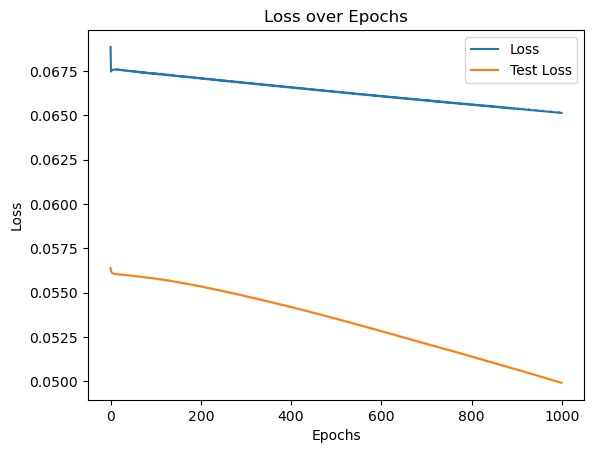

In [16]:
plt.plot(losses, label='Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

- The result is not so good:
    - We need to train for longer
    - Also, we initialized weights uniformly

- Next, we consider Xavier uniform initialization

- To speed up training, we will use batch gradient descent
    - This means that at each epoch we only go through one batch (with size set at 32 in this example)

- For larger models, we can also use GPU
    - This requires: ``` pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118```
    - It also requires compatibility between GPU and cuda version, for instance for NVIDIA GeForce RTX 4070 the cuda version needed is 11.8 or higher, and Pytorch version 2.0 or higher
    - Note that, since the model is so small, the advantage of using GPU is more than compensated by the need to send data back and forth to the right cpu/gpu formats
    - So using GPU is actually slower here
    - However, the code below can be used for GPU as well for your reference

In [18]:
# Check if GPU is available and set the device
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")
print(torch.__version__)


True
1
NVIDIA GeForce RTX 4070 Laptop GPU
2.7.0+cu118


In [8]:
class ModelX(nn.Module):
    ## input layer (4 dimensions) -> hidden layer 1 (128 dimensions) -> hidden layer 2 (64 dimensions) -> output layer (3 classes of iris flower species)
    ## The model is a simple feedforward neural network with two hidden layers.
    ## The first hidden layer has 128 neurons and the second hidden layer has 64 neurons.
    ## The activation function used is ReLU (Rectified Linear Unit).
    ## The output layer has 1 neuron, which is suitable for regression tasks.
    def __init__(self, in_features = 4, h1 = 8, h2 = 4, out_features = 3):
        super(ModelX, self).__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, out_features)
        self._init_weights()
        # Initialize weights using Xavier uniform distribution

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
print(f"Using device: {device}")

# Pick a manual seed for reproducibility
torch.manual_seed# Create an instance of the model
modelX = ModelX().to(device)
optimizer = torch.optim.Adam(modelX.parameters(), lr=0.001)

Using device: cpu


In [20]:
# Move the data to the GPU
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

# To make full use of the GPU, we will need to do batch gradient descent
# will use DataLoader to create batches of data.

train_dataset = TensorDataset(X_train, y_train) # Create a TensorDataset from the training data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # Create a DataLoader for the training data
test_dataset = TensorDataset(X_test, y_test) # Create a TensorDataset from the test data
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) # Create a DataLoader for the test data


# Training loop
num_epochs = 10000  # Number of epochs for training
losses = []  # List to store the loss values for each epoch
test_losses = []

for epoch in range(num_epochs):
    step_loss = []
    modelX.train()  # Set the model to training mode
    for data, target in train_loader:
        # Backpropagation
        optimizer.zero_grad()  # Zero the gradients
        y_pred = modelX(data)
        loss = criterion(y_pred, target)
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights
        step_loss.append(loss)

    # Average loss for the epoch
    loss = sum(step_loss) / len(step_loss)
    losses.append(loss.detach().cpu().numpy())  # Store the loss values (move to CPU for storage)

    # Evaluate on the test set
    with torch.no_grad():  # No need to compute gradients for the test set
        modelX.eval()
        step_test_loss = []
        for data, target in test_loader:
            y_test_pred = modelX(data)  # Forward pass on the test set
            test_loss = criterion(y_test_pred, target)  # Compute the test loss
            step_test_loss.append(test_loss)
        test_loss = sum(step_test_loss) / len(step_test_loss)
        test_losses.append(test_loss.detach().cpu().numpy())  # Move to CPU for storage

    # Print every 1000 epochs
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss}, Test Loss: {test_loss}")

Epoch [1000/10000], Loss: 0.23762255907058716, Test Loss: 0.23034386336803436
Epoch [2000/10000], Loss: 0.10529082268476486, Test Loss: 0.10451038926839828
Epoch [3000/10000], Loss: 0.07338607311248779, Test Loss: 0.07273206859827042
Epoch [4000/10000], Loss: 0.058910589665174484, Test Loss: 0.060312263667583466
Epoch [5000/10000], Loss: 0.05841144919395447, Test Loss: 0.053549692034721375
Epoch [6000/10000], Loss: 0.054242756217718124, Test Loss: 0.04869992658495903
Epoch [7000/10000], Loss: 0.055115699768066406, Test Loss: 0.0447271429002285
Epoch [8000/10000], Loss: 0.05152827501296997, Test Loss: 0.04146949574351311
Epoch [9000/10000], Loss: 0.04939286410808563, Test Loss: 0.03879891708493233
Epoch [10000/10000], Loss: 0.049463097006082535, Test Loss: 0.03648466616868973


- Training with batch gradient descent is 10x faster

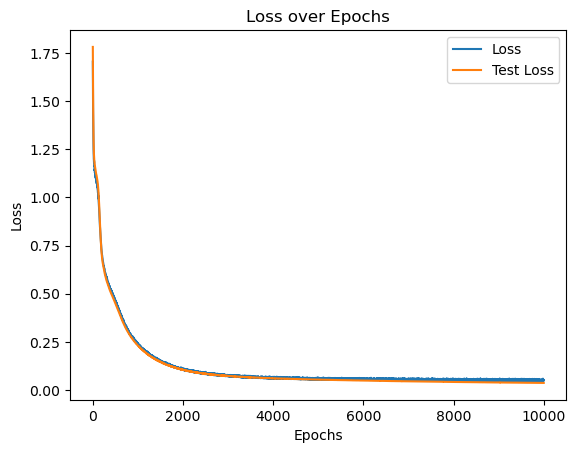

In [21]:
# Plotting the loss values
plt.plot(losses, label='Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

# 2. Self-attention mechanism